In [30]:
from pathlib import Path
import py7zr
import requests as req
import os
import pandas as pd
from lxml.etree import XMLParser, parse
xmlparser = XMLParser(huge_tree=True)
import xmltodict as xd
import bs4
import shutil
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Research Question

All online communities have a unique set of members that differ both within and between communities. Generally, communities will thrive if they're either an enjoyable or useful place for people to go to interact with others in a virtual space, on the otherhand some online communities are known to be toxic or full of trolls. We're interested in how we could use sentiment analysis to characterize different stacks on stack exchange and what interesting community traits arise from this lens.

Our specific research question is, are the distributions of post sentiment in different stack exchanges distinctly different from each other, and if so, what characterizes these distinctions?

## Data Collection

We decided to do a broad investigation by collecting all of the stacks available on this page: https://archive.org/download/stackexchange. From each stack (168), we took a random sample of 100 posts to analyze. This method allows us to analyze the full range of stacks without having an unwieldy amount of data. A random sample of N=100 should be sufficiently large to represent each stack.

In [31]:
def extract_stack(stack):

    endpoint = f"https://archive.org/download/stackexchange/{stack}.stackexchange.com.7z"
    res = req.get(endpoint, stream=True)
    path = f"../data/{stack}"
    filename = path + f"/{stack}.7z"

    if res.status_code == 200:

        if not Path(path).exists(): 
            Path(path).mkdir()

        with open(filename, 'wb') as out:
            out.write(res.content)

        with py7zr.SevenZipFile(filename, mode='r') as z:
            z.extractall(path)

        os.remove(filename)

    else: print(f"Request Failed: {res.status_code}")

parse_dict = {
    "Id": "string",
    "CreationDate": "datetime",
    "Body": "text",
    "Title": "string",
    "DisplayName": "string",
    "AccountId": "string"
}

def clean_row(row):

    cleaned_row = {}

    for key, val in row.items():
        
        if key in parse_dict.keys():
            var_type = parse_dict[key]
            if var_type == "string": cleaned_row[key] = val
            elif var_type == "datetime": cleaned_row[key] = pd.to_datetime(val)
            elif var_type == "text": cleaned_row[key] = bs4.BeautifulSoup(val, "lxml").text.replace("\n"," ")

    return cleaned_row

def xml_to_df(tree):

    rows = tree.getroot().getchildren()
    row_list = []
    for row in rows:
        cleaned = clean_row(dict(row.attrib))
        row_list.append(cleaned)
    return pd.DataFrame(row_list)


def extract_data(stack):

    path = f"../data/{stack}"
    
    post_tree = parse(path + '/Posts.xml', parser=xmlparser)
    post_df = xml_to_df(post_tree)

    user_tree = parse(path + '/Users.xml', parser=xmlparser)
    user_df = xml_to_df(user_tree)

    shutil.rmtree(path)
    Path(path).mkdir()

    post_df.to_pickle(f"../data/{stack}/post_df.pkl")
    user_df.to_pickle(f"../data/{stack}/user_df.pkl")

def get_stack_list():

    ia = req.get('https://archive.org/download/stackexchange')
    soup = bs4.BeautifulSoup(ia.content)
    table = soup.find(class_= 'directory-listing-table')

    stacks = []
    for row in table.find_all('tr'):
        name = row.find('td').text.split('.')[0]
        stacks.append(name)

    stacks = np.unique(stacks[1:])
    return stacks

def get_stack_data(stacks):

    for stack in stacks:
        try:
            extract_stack(stack)
            extract_data(stack)
        except: print(f'something failed for {stack}')

def combine_stack_data(stacks):

     posts_df = pd.DataFrame()

     for stack in stacks:

          path = f"../data/{stack}"

          if Path(path + '/post_df.pkl').exists():

            temp_df = pd.read_pickle(path + '/post_df.pkl')
            temp_df['stack'] = stack
            if len(temp_df) > 100:
                posts_df = pd.concat([posts_df, temp_df.sample(100)])
            else: 
                posts_df = pd.concat([posts_df, temp_df])

     return posts_df

In [48]:
# stacks = get_stack_list()
# get_stack_data(stacks)
# stack_df = combine_stack_data(stacks)
# stack_df.to_pickle('../data/stacks_df.pkl')
stack_df = pd.read_pickle('../data/stacks_df.pkl')
print(f"There are {stack_df.shape[0]} posts in the dataset and {stack_df.shape[1]} columns")
display(stack_df.head(5))
print(stack_df.shape)

There are 16800 posts in the dataset and 5 columns


,Id,CreationDate,Body,Title,stack
4858,6598,2018-08-08 15:30:29.177,I change the stepper driver and that helped. O...,NaN,3dprinting
13537,19892,2022-09-10 08:42:02.967,I usually see Ender 3's set at 93 for the E-st...,New Ender 3 E-steps off by 367?,3dprinting
3747,5330,2018-01-23 06:26:02.883,"So after 5 days of trouble shooting, Bob-the-K...",NaN,3dprinting
11733,16798,2021-07-26 11:26:21.853,"As suggested in comments, I've installed Luke ...",NaN,3dprinting
537,556,2016-02-11 14:00:12.313,I had a repeatable problem where my prints wer...,NaN,3dprinting


(16800, 5)


## Operationalizing Sentiment

We decided to use the Vader Sentiment Analyzer to score each post's sentiment. We used the compound score since it captures both the upside ("pos" score) and downside ("neg" score) in one metric. We then aggregated these scores by stack to get an idea of what the range of stack-level sentiments is on the platform. 

Next, we took the stacks with the highest and lowest variance as we thought this could be an interesting way to characterize them. High variance stacks may have bimodal distributions which could indicate two distinct groups of "negative" and "positive" members within the community or it could simply be a wider normal distribution.

In [34]:
analyzer = SentimentIntensityAnalyzer()

In [49]:
sample_df = stack_df

senti_sr = sample_df['Body'].map(
    lambda text: analyzer.polarity_scores(text))

senti_df = pd.json_normalize(senti_sr)
senti_df.index = senti_sr.index

sample_df = pd.concat([sample_df, senti_df],axis=1)

display(sample_df[["Body","pos","neg","compound", "stack"]].head())

,Body,pos,neg,compound,stack
4858,I change the stepper driver and that helped. O...,0.000,0.000,0.0000,3dprinting
13537,I usually see Ender 3's set at 93 for the E-st...,0.087,0.055,0.7892,3dprinting
3747,"So after 5 days of trouble shooting, Bob-the-K...",0.091,0.077,0.8049,3dprinting
11733,"As suggested in comments, I've installed Luke ...",0.067,0.044,0.7266,3dprinting
537,I had a repeatable problem where my prints wer...,0.054,0.056,0.2144,3dprinting


In [50]:
mean_df = sample_df.groupby("stack")[['stack', 'neg', 'pos','compound']].mean().reset_index()
mean_df.sort_values(by='compound', ascending = True).head(10)

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_1176/1713557876.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = sample_df.groupby("stack")[['stack', 'neg', 'pos','compound']].mean().reset_index()


,stack,neg,pos,compound
119,portuguese,0.02726,0.01273,-0.201977
64,german,0.06585,0.04767,-0.113749
133,scifi,0.07790,0.06725,-0.111910
129,rus,0.00000,0.00274,0.016530
155,ukrainian,0.00069,0.00319,0.019794
137,skeptics,0.06596,0.06129,0.027053
79,italian,0.02528,0.03035,0.029591
86,law,0.07457,0.07464,0.031481
59,french,0.02316,0.03045,0.040094
143,spanish,0.03085,0.05317,0.055214


In [61]:
sample_df_grouped = sample_df.groupby("stack")[['compound']].agg(['mean', 'median', 'var'])
sample_df_sorted_var = sample_df_grouped.droplevel(0, axis=1).sort_values(by='var', ascending = True)

#List of stack names with top 10 var in post sentiment 
top_var_stacks = list(sample_df_sorted_var.sort_values(by='var', ascending = False).head(10).index)
bottom_var_stacks = list(sample_df_sorted_var.sort_values(by='var', ascending = False).tail(10).index)

#DataFrame with all posts from each of the top 10 var stacks 
top_var_stack_posts = sample_df[sample_df['stack'].isin(top_var_stacks)].copy()
top_var_stack_posts.rename(columns = {'compound':'Sentiment','stack':'Stack'},inplace=True)

bottom_var_stack_posts = sample_df[sample_df['stack'].isin(bottom_var_stacks)].copy()
bottom_var_stack_posts.rename(columns = {'compound':'Sentiment','stack':'Stack'},inplace=True)
print('Stacks with the highest variance')
print(top_var_stacks)
print('Stacks with the lowest variance')
print(bottom_var_stacks)

Stacks with the highest variance
['skeptics', 'christianity', 'rpg', 'law', 'moderators', 'hermeneutics', 'politics', 'history', 'philosophy', 'buddhism']
Stacks with the lowest variance
['homebrew', 'opendata', 'portuguese', 'hardwarerecs', 'computergraphics', 'softwarerecs', 'windowsphone', 'materials', 'ukrainian', 'rus']


## Visualizations

We decided to do some side by side visualizations to compare the distribution of these groups using an ordered bar chart, boxplots and relative frequency distribution charts. 

The boxplots confirmed the groups had vastly different variances with the high variance stacks having interquartile ranges over 1 unit wide while the low variance interquartile ranges were around half a unit wide. 

The relative frequency distributions answered our intermediate question about whether high variance stacks would have bimodal distributions or just be wide normal distributions. Interestingly, we can see a common characteristic where there is a larger, highly positive group of posts and then a smaller but highly negative group. This could potentially be story of mostly positive groups with some negtive trolls or the stack could be about contentious topics where there are postive and negative takes in unequal proportions. 


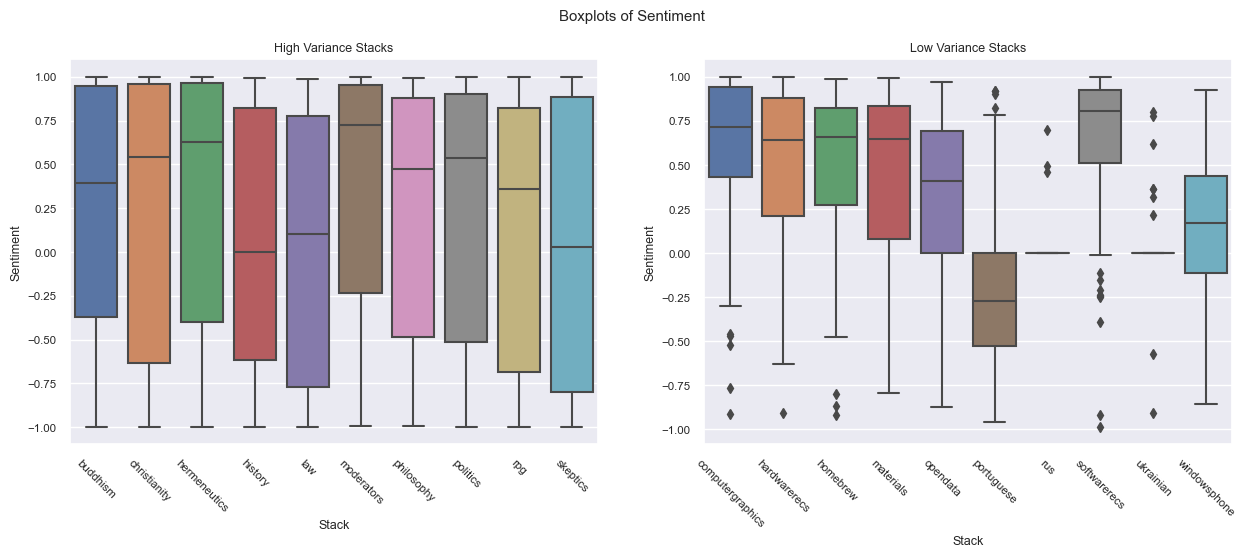

In [92]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle('Boxplots of Sentiment')

sns.set(font_scale=0.75)

sns.boxplot(x=top_var_stack_posts['Stack'], y=top_var_stack_posts['Sentiment'], ax=axes[0]).set(title="High Variance Stacks")
axes[0].xaxis.set_tick_params(rotation=-45)
sns.boxplot(x=bottom_var_stack_posts['Stack'], y=bottom_var_stack_posts['Sentiment'], ax=axes[1]).set(title="Low Variance Stacks")
axes[1].xaxis.set_tick_params(rotation=-45)

plt.show()

[Text(0.5, 1.0, 'Low Variance Stacks')]

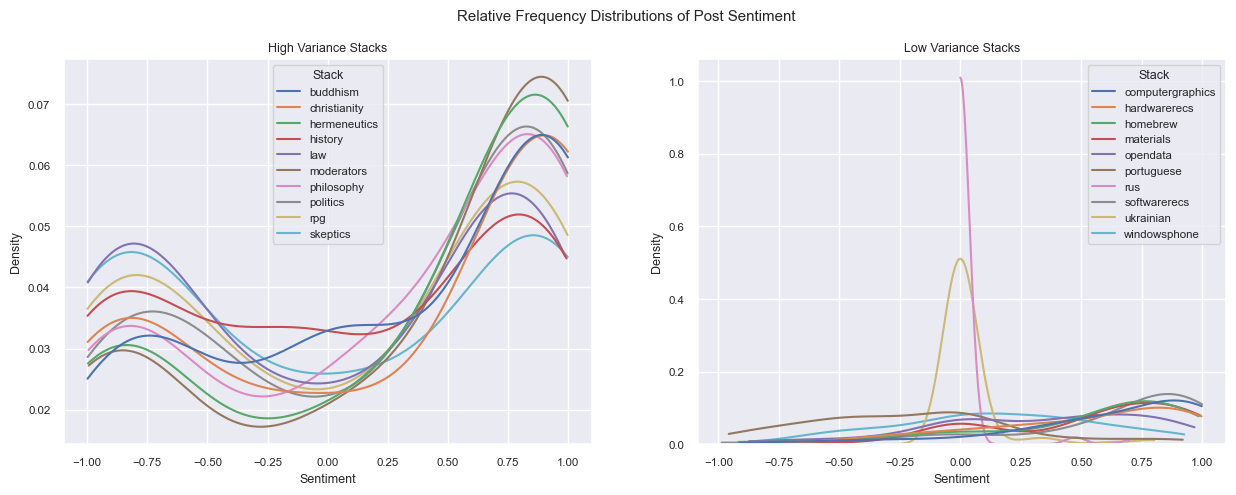

In [91]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle('Relative Frequency Distributions of Post Sentiment')

sns.kdeplot(data=top_var_stack_posts, x='Sentiment', hue='Stack', legend=True,
            cut=0, warn_singular=False, bw_adjust=1, ax=axes[0]).set(title='High Variance Stacks')

sns.kdeplot(data=bottom_var_stack_posts, x='Sentiment', hue='Stack', legend=True,
            cut=0, warn_singular=False, bw_adjust=1, ax=axes[1]).set(title='Low Variance Stacks')

## Conclusions

We've found an answer to our original research question, *are the distributions of post sentiment in different stack exchanges distinctly different from each other, and if so, what characterizes these distinctions?* In particular, along the dimension of post sentiment variance, high variance posts generally have a bimodal distribution that indicates some divergence in either the members or post types. An interesting extension could be whether these distinct groups of posts correlates with distinct groups of users. 